In [263]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/celiasagastume/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [264]:
data = pd.read_csv("lr_output.csv")
mapper = {"Unnamed: 0": "Comment_ID"}
data=data.rename(columns=mapper)
data.head()

,Comment_ID,text,target,model_probability,prediction
0,2245,Stefano \nIt would be a much better world if ...,1,0.652880,1
1,6577,"""\nThey might seem silly to you, but try watch...",1,0.573590,1
2,5141,"""\n\nI am the person who made the page about ""...",1,0.586840,1
3,2758,Women Preachers \n\nWhy do so called Christia...,1,0.672019,1
4,4618,"""\n\n Your Lie(s) About Me \n\nYou wrote:\n""""F...",1,0.582802,1


In [265]:
#load comments 
comments = pd.read_csv("comments.csv")

In [266]:
#seperate X and y in comments df
X, y = comments['text'], comments['target']

In [267]:
#create text clean + tokenizer function

punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~__'
words = set(nltk.corpus.words.words())
stop = stopwords.words('english')
stop.append('the')
stemmer = SnowballStemmer(language='english')
cv_tfidf = TfidfVectorizer(preprocessor=' '.join)





def to_token(text):
    
   
    text = [text.translate(str.maketrans('', '', string.punctuation))]
    text = [word_tokenize(word) for word in text]
    text = [item for sublist in text for item in sublist]
    text = [stemmer.stem(word) for word in text]
    text = [re.sub(r'http\S+', '', each) for each in text]
    text = [re.sub('[0-9+]', '', each) for each in text]
    text = [re.sub('_', '', each) for each in text]
    text = [re.sub("\n","",each) for each in text]
    text = [re.sub('/_/g', '', each) for each in text]
    text = [re.sub('[^\u0000-\u05C0\u2100-\u214F]+', '', each) for each in text]
    text = [re.sub('[\u0401\u0451\u0410-\u044f]', '', each) for each in text]
    text = [w for w in text if not w.lower() in stop]
    text = [word.lower() for word in text]
    text = [word for word in text if word not in stop]
    text = ["".join(dict.fromkeys(word)) for word in text]

    
    return text

In [268]:
#create series of all unique comments in the dataset

corpus = [word for word in X]


# #tokenize train and test sets 

features = [to_token(comment) for comment in corpus]

In [272]:
#create tfidf vector matrix for all comments
cv = CountVectorizer()
feat = [str (item) for item in features]
trans = cv.fit_transform(feat)
cv_df = pd.DataFrame(trans.toarray(), columns = cv.get_feature_names_out())

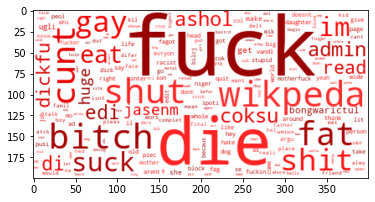

In [363]:
#create wordcloud of comments classified as toxic 
toxic = data[data['model_probability']>.95]
toxic =toxic['Comment_ID']

toxic_comments = cv_df.iloc[toxic,:].sum()
import random
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%%, %d%%)" % random.randint(30, 60)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(toxic_comments)
plt.imshow(wordcloud.recolor(color_func=red_color_func, random_state=3),
           interpolation="bilinear")
plt.savefig("toxic_wordcloud.png", dpi=400)
#plt.imshow(wordcloud)


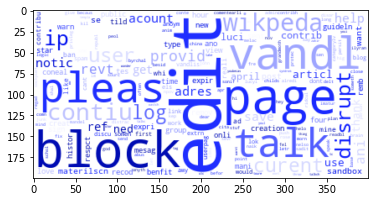

In [359]:
#create wordcloud of comments classified as not toxic 
not_toxic = data[data['model_probability']<0.4]
not_toxic =not_toxic['Comment_ID']

def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(236, 100%%, %d%%)" % random.randint(30, 100)

not_toxic_comments = cv_df.iloc[not_toxic,:].sum()


wordcloud = WordCloud(background_color="white").generate_from_frequencies(not_toxic_comments)
plt.imshow(wordcloud.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")

plt.savefig("not_toxic_wordcloud.png", dpi=400)
#plt.imshow(wordcloud)

In [345]:
toxic_top20=pd.DataFrame(toxic_comments.T.sort_values(ascending=False)[0:50])
fig = px.bar(toxic_top20, x=toxic_top20.index, y=0,
             color_discrete_sequence =['red']*(len(toxic_top20)),
             title='Count of Top Words in Toxic Comments', 
             template='plotly_white', 
             labels={'index': 'Word', '0': 'Count'})
fig.update_traces(marker_color='red')
fig.show()

In [346]:
not_toxic_top20=pd.DataFrame(not_toxic_comments.T.sort_values(ascending=False)[0:50])
fig = px.bar(not_toxic_top20, x=not_toxic_top20.index, y=0,
             color_discrete_sequence =['red']*(len(toxic_top20)),
             title='Count of Top Words in Not Toxic Comments', 
             template='plotly_white', 
             labels={'index': 'Word', '0': 'Count'})
fig.update_traces(marker_color='blue')
fig.show()

In [355]:
not_toxic_top20['Label'] = 'Not Toxic'
toxic_top20['Label'] = 'Toxic'

together_2 = pd.concat([not_toxic_top20, toxic_top20])
mapper = {0:'Count'}
together_2=together_2.rename(columns=mapper)

together_2.head()

,Count,Label
edit,46,Not Toxic
block,44,Not Toxic
page,41,Not Toxic
vandl,35,Not Toxic
pleas,31,Not Toxic


In [364]:
data.sort_values(by='model_probability').head(10)

,Comment_ID,text,target,model_probability,prediction
2608,2602,Warning #2 \n\n Please stop your disruptive e...,1,0.271485,0
2481,1967,Please stop your disruptive editing. If your ...,0,0.279958,0
2351,4292,"""\n\n Please stop your disruptive editing. If ...",1,0.279958,0
1094,1968,Please stop your disruptive editing. If your ...,1,0.279958,0
950,4295,"""\n\n Please stop your disruptive editing. If ...",0,0.279958,0
9,4291,"""\n\n Please stop your disruptive editing. If ...",1,0.279958,0
2780,4299,"""\n\n Please stop your disruptive editing. If ...",1,0.279958,0
1912,4305,"""\n\n Please stop. If you continue to vandaliz...",0,0.301219,0
1707,1962,Please stop your disruptive editing. If you c...,0,0.317824,0
896,18,\n\nVandalism \nThis page is vandalized someo...,1,0.318633,0


In [366]:
data.iloc[2481,1]

' Please stop your disruptive editing. If your vandalism continues, you will be blocked from editing Wikipedia.   42 '

In [367]:
data.sort_values(by='model_probability').tail(10)

,Comment_ID,text,target,model_probability,prediction
775,3201,"fuck you \n\n fuck you fuck wekipedia, fuck a...",1,0.997499,1
2055,13393,fuck this this is bull shit and it does not ev...,1,0.997855,1
2383,11566,Suck my cock you stupid bitch!:),1,0.998103,1
1809,2797,YOU SUCK \n\nI HATE YOU> YOU CAN FUCK MY ASS ...,1,0.998104,1
1967,291,"ASS \n\nYou piece of fucking shit, your mothe...",1,0.998474,1
2584,922,Fuck you... \n\nASSSSSSS,1,0.998517,1
2721,907,Fuck you \n\nYou're a stupid bitch 142.162.85...,1,0.998992,1
906,8749,"FUCK YOU, YOU GAY ASS LIBERAL!!!\nhey asshole ...",1,0.998999,1
2700,903,Fuck you \n\nFuck off you stupid bitch (142.1...,1,0.999369,1
2248,3103,bitch \nyou are a fucking hore. you suck dick...,1,0.999597,1


In [368]:
data.iloc[2248,1]

" bitch \nyou are a fucking hore. you suck dick you big ass hole. you are gay you faggot ass bitch. you can go to hell you bitch ass motherfucker, suck a big dick asshole. i'm fuckin your mom ho. she can't get off my dick. your daddy probably raped you in the ass everyday when you were young you stupid ass motherfuck."